In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

import shapefile
from matplotlib.patches import Polygon
import mpld3

from censusgeocode import CensusGeocode

### 311 Request files

In [126]:
requests = pd.read_csv('get_it_done.csv')

In [127]:
len(requests)

10833

In [139]:
graffiti = requests.loc[np.where(requests['Problem Category']=='Graffiti')[0]]
graffiti.reset_index(drop=True, inplace=True)

dump = requests.loc[np.where(requests['Problem Category']=='Litter/Dumping')[0]]
dump.reset_index(drop=True, inplace=True)

In [140]:
len(graffiti), len(dump)

(2013, 27)

In [142]:
graffiti.head()

,Case Number,Problem Category,Geolocation (Latitude),Geolocation (Longitude),Opened Date,Subject,Status,Public Description,SAP URL,Closed Date,Age (Days)
0,96555,Graffiti,32.695569,-117.106023,7/29/16,"Graffiti Removal at 4102 NATIONAL AV, 92113",Closed,Request graffiti removed from fence,https://getitdone.force.com//TSWViewReportDeta...,8/4/16,5
1,96577,Graffiti,32.744808,-117.111836,7/29/16,"Graffiti at 3601-3699 38th Street San Diego, ...",Closed,Gang grafitti 3' long,https://getitdone.force.com//TSWViewReportDeta...,8/9/16,10
2,96578,Graffiti,32.744719,-117.111776,7/29/16,"Graffiti at 3601-3699 38th Street San Diego, ...",Closed,Grafitti,https://getitdone.force.com//TSWViewReportDeta...,8/9/16,10
3,96581,Graffiti,32.717225,-117.166572,7/29/16,Graffiti at 32.72N 117.17W,Closed,Elevator 3,https://getitdone.force.com//TSWViewReportDeta...,8/9/16,10
4,96594,Graffiti,32.739297,-117.133569,7/29/16,"Graffiti at 3303 28th St, San Diego, CA 92104...",Closed,on the northeast corner of Thorn and 28th. it...,https://getitdone.force.com//TSWViewReportDeta...,8/6/16,7


### Extract Census linking information for request locations 

CensusGeocode

In [153]:
cg = CensusGeocode()

In [148]:
graffiti.loc[i,['Geolocation (Longitude)', 'Geolocation (Latitude)']].astype(float)

Geolocation (Longitude)   -117.106023
Geolocation (Latitude)      32.695569
Name: 0, dtype: float64

In [154]:
cg.coordinates(x=graffiti.loc[0,'Geolocation (Longitude)'].astype(float), 
                              y=graffiti.loc[0, 'Geolocation (Latitude)'].astype(float))

KeyboardInterrupt: 

In [144]:
graffiti['block']=None
graffiti['tract']=None
graffiti['geoid']=None

for i in range(0,10): 
    if (graffiti.loc[i,'Geolocation (Longitude)']!=0.0) :
        temp = cg.coordinates(x=graffiti.loc[i,'Geolocation (Longitude)'], 
                              y=graffiti.loc[i, 'Geolocation (Latitude)'])[0]['2010 Census Blocks'][0]
        graffiti.loc[i, 'block'] = temp['BLOCK']
        graffiti.loc[i, 'tract'] = temp['TRACT']
        graffiti.loc[i, 'geoid'] = temp['GEOID']

ValueError: No JSON object could be decoded

In [120]:
census.columns.values

array(['Id', 'Id2', 'Geography', 'Total:', 'Owner occupied',
       'Renter occupied', 'Id2_1', 'Geography_1', 'Total:_1', 'For rent',
       'For sale only', 'Rented or sold, not occupied',
       'For seasonal, recreational, or occasional use',
       'For migrant workers', 'Other vacant', 'Id2_2', 'Geography_2',
       'Total:_2', 'Householder who is White alone',
       'Householder who is Black or African American alone',
       'Householder who is American Indian and Alaska Native alone',
       'Householder who is Asian alone',
       'Householder who is Native Hawaiian and Other Pacific Islander alone',
       'Householder who is Some other race alone',
       'Householder who is Two or more races', 'Id2_3', 'Geography_3',
       'RECORD CODES - File Identification',
       'RECORD CODES - State/US-Abbreviation (USPS)',
       'RECORD CODES - Summary Level',
       'RECORD CODES - Geographic Component',
       'RECORD CODES - Characteristic Iteration',
       'RECORD CODES - Ch

In [123]:
census[['Id', 'Id2', 'GEOGRAPHIC AREA CODES - Census Tract','GEOGRAPHIC AREA CODES - Block Group','GEOGRAPHIC AREA CODES - Block']]

,Id,Id2,GEOGRAPHIC AREA CODES - Census Tract,GEOGRAPHIC AREA CODES - Block Group,GEOGRAPHIC AREA CODES - Block
0,1000000US060730001001000,60730001001000,100.0,1.0,1000
1,1000000US060730001001001,60730001001001,100.0,1.0,1001
2,1000000US060730001001002,60730001001002,100.0,1.0,1002
3,1000000US060730001001003,60730001001003,100.0,1.0,1003
4,1000000US060730001001004,60730001001004,100.0,1.0,1004
5,1000000US060730001001005,60730001001005,100.0,1.0,1005
6,1000000US060730001001006,60730001001006,100.0,1.0,1006
7,1000000US060730001001007,60730001001007,100.0,1.0,1007
8,1000000US060730001001008,60730001001008,100.0,1.0,1008
9,1000000US060730001001009,60730001001009,100.0,1.0,1009


In [108]:
requests[['block', 'tract', 'geoid']]

,block,tract,geoid
0,1009,017044,060730170441009
1,None,None,None
2,1004,008347,060730083471004
3,None,None,None
4,None,None,None
5,None,None,None
6,None,None,None
7,None,None,None
8,None,None,None
9,1004,008347,060730083471004


In [119]:
requests['geoid'].str[1:]

0      60730170441009
1                None
2      60730083471004
3                None
4                None
5                None
6                None
7                None
8                None
9      60730083471004
10     60730083332031
11     60730083332031
12     60730083332031
13     60730083471004
14     60730083471004
15     60730083332031
16     60730083332017
17     60730083332031
18     60730083332031
19     60730083332031
20     60730083471004
21     60730083471004
22     60730083332031
23     60730083332031
24     60730083332031
25     60730083332017
26     60730083332031
27     60730083471011
28     60730083471012
29     60730083471004
            ...      
170              None
171              None
172              None
173              None
174              None
175              None
176              None
177              None
178              None
179              None
180              None
181              None
182              None
183              None
184       

In [101]:
temp = cg.coordinates(x=requests.loc[0:5, 'long'], y=requests.loc[0:5, 'lat'])[0]['2010 Census Blocks'][0]['BLOCK']

In [104]:
cg.coordinates(x=requests.loc[0:5, 'long'], y=requests.loc[0:5, 'lat'])

1

### Census information by block group

factfinder.census.gov

In [111]:
filenames='aff/blocks/D*with_ann.csv'
test=glob.glob(filenames)

In [114]:
for i in range(0,len(test)): 
    temp = pd.read_csv(test[i], header=1)
    print i, i, i 
    if (i==0): 
        census = temp.copy()
    if (i!=0): 
        combo = pd.merge(census, temp, on='Id', how='left', suffixes=('', '_' + str(i)))
        census = combo.copy()
        census.reset_index(drop=True)

0 0 0
1 1 1
2 2 2


/Users/kschles/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,19,24,26,27,29,30,31,32,33,34,35,36,37,38,39,44,46,47,54,55,56,57,63,64,65,71,78,81,82,83,84,85,86,101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3 3 3
4 4 4


/Users/kschles/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5 5 5


/Users/kschles/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,18,19,21,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,44,45,46,47,50,51,54,55,56,57,60,61,62,63,64,65,71,78,81,82,83,84,85,86,87,97,99,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


6 6 6
7 7 7
8 8 8
9 9 9
10 10 10
11 11 11
12 12 12
13 13 13
14 14 14
15 15 15
16 16 16
17 17 17
18 18 18
19 19 19
20 20 20
21 21 21
22 22 22
23 23 23


In [116]:
census.loc[0:10, ['Id', 'Id2', 'Geography', 'GEOGRAPHIC AREA CODES - Block', 'GEOGRAPHIC AREA CODES - Urban/Rural']]

,Id,Id2,Geography,GEOGRAPHIC AREA CODES - Block,GEOGRAPHIC AREA CODES - Urban/Rural
0,1000000US060730001001000,60730001001000,"Block 1000, Block Group 1, Census Tract 1, San...",1000,
1,1000000US060730001001001,60730001001001,"Block 1001, Block Group 1, Census Tract 1, San...",1001,
2,1000000US060730001001002,60730001001002,"Block 1002, Block Group 1, Census Tract 1, San...",1002,
3,1000000US060730001001003,60730001001003,"Block 1003, Block Group 1, Census Tract 1, San...",1003,
4,1000000US060730001001004,60730001001004,"Block 1004, Block Group 1, Census Tract 1, San...",1004,
5,1000000US060730001001005,60730001001005,"Block 1005, Block Group 1, Census Tract 1, San...",1005,
6,1000000US060730001001006,60730001001006,"Block 1006, Block Group 1, Census Tract 1, San...",1006,
7,1000000US060730001001007,60730001001007,"Block 1007, Block Group 1, Census Tract 1, San...",1007,
8,1000000US060730001001008,60730001001008,"Block 1008, Block Group 1, Census Tract 1, San...",1008,
9,1000000US060730001001009,60730001001009,"Block 1009, Block Group 1, Census Tract 1, San...",1009,


In [115]:
census.columns.values

array(['Id', 'Id2', 'Geography', 'Total:', 'Owner occupied',
       'Renter occupied', 'Id2_1', 'Geography_1', 'Total:_1', 'For rent',
       'For sale only', 'Rented or sold, not occupied',
       'For seasonal, recreational, or occasional use',
       'For migrant workers', 'Other vacant', 'Id2_2', 'Geography_2',
       'Total:_2', 'Householder who is White alone',
       'Householder who is Black or African American alone',
       'Householder who is American Indian and Alaska Native alone',
       'Householder who is Asian alone',
       'Householder who is Native Hawaiian and Other Pacific Islander alone',
       'Householder who is Some other race alone',
       'Householder who is Two or more races', 'Id2_3', 'Geography_3',
       'RECORD CODES - File Identification',
       'RECORD CODES - State/US-Abbreviation (USPS)',
       'RECORD CODES - Summary Level',
       'RECORD CODES - Geographic Component',
       'RECORD CODES - Characteristic Iteration',
       'RECORD CODES - Ch

In [33]:
census.loc[0:10, ['GEOGRAPHIC AREA CODES - Block Group', 'GEOGRAPHIC AREA CODES - Census Tract']]

,GEOGRAPHIC AREA CODES - Block Group,GEOGRAPHIC AREA CODES - Census Tract
0,1,100
1,2,100
2,1,201
3,1,202
4,2,202
5,3,202
6,1,300
7,2,300
8,3,300
9,4,300


In [29]:
census.columns.values

array(['Id', 'Id2', 'Geography', 'Estimate; Total:',
       'Margin of Error; Total:', 'Estimate; Male:',
       'Margin of Error; Male:', 'Estimate; Male: - Under 5 years',
       'Margin of Error; Male: - Under 5 years',
       'Estimate; Male: - 5 to 9 years',
       'Margin of Error; Male: - 5 to 9 years',
       'Estimate; Male: - 10 to 14 years',
       'Margin of Error; Male: - 10 to 14 years',
       'Estimate; Male: - 15 to 17 years',
       'Margin of Error; Male: - 15 to 17 years',
       'Estimate; Male: - 18 and 19 years',
       'Margin of Error; Male: - 18 and 19 years',
       'Estimate; Male: - 20 years', 'Margin of Error; Male: - 20 years',
       'Estimate; Male: - 21 years', 'Margin of Error; Male: - 21 years',
       'Estimate; Male: - 22 to 24 years',
       'Margin of Error; Male: - 22 to 24 years',
       'Estimate; Male: - 25 to 29 years',
       'Margin of Error; Male: - 25 to 29 years',
       'Estimate; Male: - 30 to 34 years',
       'Margin of Error; Male:

### Census block Shapefiles

http://rdw.sandag.org/Account/gisdtview?dir=Census

In [23]:
reader = shapefile.Reader('CENSUS_BLOCKS_2010/CENSUS_BLOCKS_2010.shp')

In [24]:
shapes = reader.shapes()

In [17]:
#namer = reader.shapeRecords()

In [26]:
reader.records()[0]

[1000, 29.03, '3.20906312364e+006', '1.20040564487e+004']

In [18]:
reader.records()[0]

[1000, 29.03, '3.20906312364e+006', '1.20040564487e+004']

In [ ]:
bg_info = pd.DataFrame(reader.records())

In [19]:
dir(shapes[0])

['__doc__',
 '__geo_interface__',
 '__init__',
 '__module__',
 'bbox',
 'parts',
 'points',
 'shapeType']

In [21]:
len(shapes)

39931

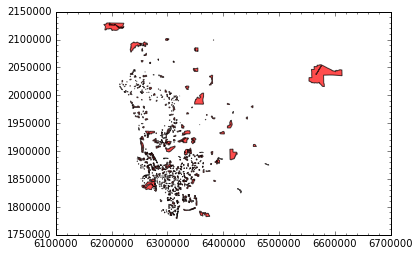

In [22]:
for i in range(0,1000): 
    barf = pd.DataFrame(shapes[i].points)
    poly = plt.Polygon(barf[[0,1]], fc='r', ec='k', alpha=0.7)
    plt.gca().add_patch(poly)

plt.axis('scaled')
plt.minorticks_on()

plt.show()